## Named Entity Recognition using Unidirectional LSTMs

In this notebook we train a Unidirectional LSTM model for Named Entity Recognition on CoNLL English dataset.

Dataset: CoNLL 2002 English Dataset

In [1]:
from keras.models import Sequential
import numpy as np
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.cross_validation import train_test_split
from keras.layers import merge, TimeDistributed, Dropout, Bidirectional, Flatten, Masking
from keras.backend import tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as f_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pandas as p
import numpy
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.
c:\users\abhishek\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\abhishek\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
raw = open('/data/eng.train', 'r',encoding="Latin-1").readlines()

print(raw[:50])

['-DOCSTART- -X- O O\n', '\n', 'EU NNP I-NP I-ORG\n', 'rejects VBZ I-VP O\n', 'German JJ I-NP I-MISC\n', 'call NN I-NP O\n', 'to TO I-VP O\n', 'boycott VB I-VP O\n', 'British JJ I-NP I-MISC\n', 'lamb NN I-NP O\n', '. . O O\n', '\n', 'Peter NNP I-NP I-PER\n', 'Blackburn NNP I-NP I-PER\n', '\n', 'BRUSSELS NNP I-NP I-LOC\n', '1996-08-22 CD I-NP O\n', '\n', 'The DT I-NP O\n', 'European NNP I-NP I-ORG\n', 'Commission NNP I-NP I-ORG\n', 'said VBD I-VP O\n', 'on IN I-PP O\n', 'Thursday NNP I-NP O\n', 'it PRP B-NP O\n', 'disagreed VBD I-VP O\n', 'with IN I-PP O\n', 'German JJ I-NP I-MISC\n', 'advice NN I-NP O\n', 'to TO I-PP O\n', 'consumers NNS I-NP O\n', 'to TO I-VP O\n', 'shun VB I-VP O\n', 'British JJ I-NP I-MISC\n', 'lamb NN I-NP O\n', 'until IN I-SBAR O\n', 'scientists NNS I-NP O\n', 'determine VBP I-VP O\n', 'whether IN I-SBAR O\n', 'mad JJ I-NP O\n', 'cow NN I-NP O\n', 'disease NN I-NP O\n', 'can MD I-VP O\n', 'be VB I-VP O\n', 'transmitted VBN I-VP O\n', 'to TO I-PP O\n', 'sheep NN I-

In [3]:
all_x = []

point = []

for line in raw:
    stripped_line = line.strip().split(' ')
    point.append(stripped_line)
    if line == '\n':
        all_x.append(point[:-1])
        point = []
        
all_x = all_x[:-1]

print(all_x[:1])

[[['-DOCSTART-', '-X-', 'O', 'O']]]


In [4]:
lengths = [len(x) for x in all_x]
print('Input sequence length range (Max, Min): ({},{})'.format(max(lengths), min(lengths)))

Input sequence length range (Max, Min): (113,1)


In [5]:
# short_x = [x for x in all_x if len(x) < 64]

# print(short_x[:1])

In [16]:
X = [[c[0] for c in x] for x in all_x]
Y = [[c[3] for c in y] for y in all_x]

print(X[2])
print(Y[2])

['Peter', 'Blackburn']
['I-PER', 'I-PER']


In [17]:
all_text = [c for x in X for c in x]

#all_text.append("ENDPAD")

all_labels = [c for y in Y for c in y]

n_labels = len(set(all_labels))

print("No. of words and labels (Words, Labels): ({},{})".format(len(all_text),n_labels))
#print(all_text[:1])

No. of words and labels (Words, Labels): (204563,8)


In [18]:
words = list(set(all_text))
words.append("ENDPAD")
word2ind = {word: index for index, word in enumerate(words)}
print(word2ind["ENDPAD"])

ind2word = {index: word for index, word in enumerate(words)}
#print(ind2word[8505])

labels = list(set([c for x in Y for c in x]))
labels.append("UNK")
#print(labels)

label2ind = {label: (index + 1) for index, label in enumerate(labels)}
#print(label2ind[])

ind2label = {(index + 1): label for index, label in enumerate(labels)}
#print(ind2label)

print('Vocabulary size: (Max, Min): ({},{})'.format(len(word2ind), len(label2ind)))

23624
Vocabulary size: (Max, Min): (23625,9)


In [19]:
word2ind['.']

2089

In [20]:
X_vec = [[word2ind[w] for w in s] for s in X]

y_vec = [[label2ind[w] for w in s] for s in Y]

In [21]:
print((y_vec[0]))

[1]


In [22]:
print(len(X_vec))

14986


In [23]:
# maxlen = max([len(x) for x in X])
# print('Maximum sequence length:', maxlen)

maxlen=50
print(words[len(words)-1])
print(label2ind['O'])

ENDPAD
1


In [24]:
X = pad_sequences(maxlen=maxlen, sequences=X_vec, padding="post",value=len(words)-1)
y = pad_sequences(maxlen=maxlen, sequences=y_vec, padding="post",value=label2ind['O'])

print(X[0][49])
print(y[0][49])

23624
1


In [25]:
y = [to_categorical(i, num_classes=n_labels+1) for i in y]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print ('Training and testing tensor shapes:', X_train[0].shape, X_test[0].shape, y_train[0].shape, y_test[0].shape)

Training and testing tensor shapes: (50,) (50,) (50, 9) (50, 9)


In [27]:
# max_features = len(word2ind)
# embedding_size = 37589
# hidden_size = 32
# out_size = len(label2ind) + 1

In [71]:
model = Sequential()
model.add(Embedding(input_dim=len(words),output_dim=maxlen, input_length=maxlen))
model.add((LSTM(units=200, return_sequences=True, dropout=0.5, recurrent_dropout=0.25)))
model.add((Dense(len(label2ind), activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 50)            1181250   
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 200)           200800    
_________________________________________________________________
dense_14 (Dense)             (None, 50, 9)             1809      
Total params: 1,383,859
Trainable params: 1,383,859
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.4)

Train on 8092 samples, validate on 5395 samples
Epoch 1/5
8092/8092 [==============================] - 55s 7ms/step - loss: 0.2099 - acc: 0.9518 - val_loss: 0.1110 - val_acc: 0.9621
Epoch 2/5
 736/8092 [=>............................] - ETA: 40s - loss: 0.0986 - acc: 0.9627 ETA: 40s - loss: 0.0987 - acc: 0.96

KeyboardInterrupt: 

In [56]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

hist = pandas.DataFrame(history.history)

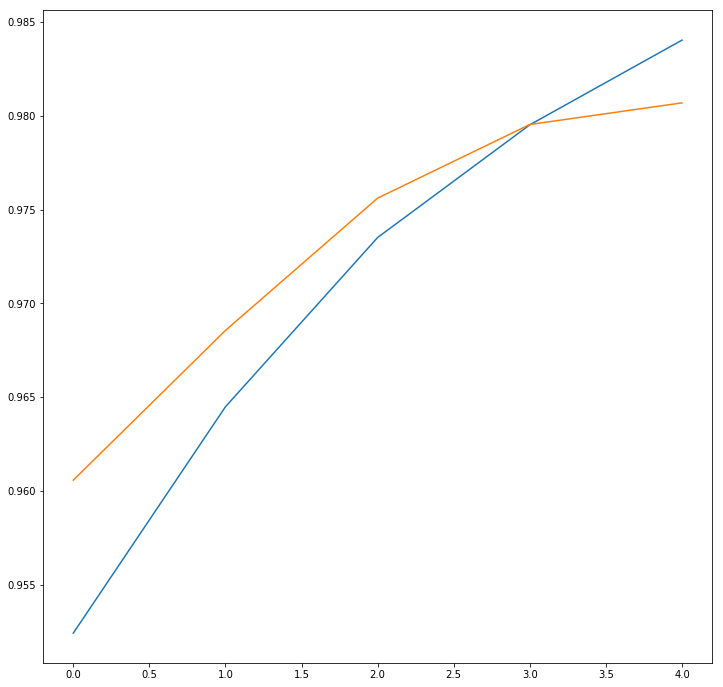

In [57]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

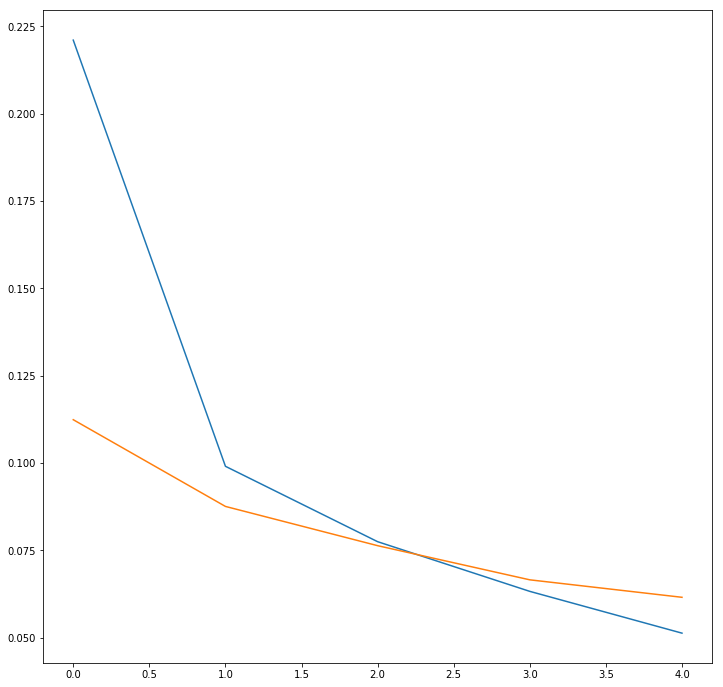

In [58]:
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [45]:
print(np.argmax(y_test, -1))

[[1 1 1 ... 1 1 1]
 [1 5 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [6 6 1 ... 1 1 1]
 [6 1 1 ... 1 1 1]]


In [46]:
i = 1
#print("X_test is: {}".format(X_test[i]))
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, t, pred in zip(X_test[i], true, p[0]):
    print("{:15}: {:5} {}".format(words[w], labels[t], labels[pred]))

Word            (True ): Pred
The            : I-MISC I-MISC
SPLA           : I-PER I-PER
has            : I-MISC I-MISC
fought         : I-MISC I-MISC
Khartoum       : I-ORG I-ORG
's             : I-MISC I-MISC
government     : I-MISC I-MISC
forces         : I-MISC I-MISC
in             : I-MISC I-MISC
the            : I-MISC I-MISC
south          : I-MISC I-MISC
since          : I-MISC I-MISC
1983           : I-MISC I-MISC
for            : I-MISC I-MISC
greater        : I-MISC I-MISC
autonomy       : I-MISC I-MISC
or             : I-MISC I-MISC
independence   : I-MISC I-MISC
of             : I-MISC I-MISC
the            : I-MISC I-MISC
mainly         : I-MISC I-MISC
Christian      : B-LOC I-PER
and            : I-MISC I-MISC
animist        : I-MISC I-MISC
region         : I-MISC I-MISC
from           : I-MISC I-MISC
the            : I-MISC I-MISC
Moslem         : B-LOC B-LOC
,              : I-MISC I-MISC
Arabised       : I-ORG I-MISC
north          : I-ORG I-MISC
.              : I-

In [ ]:
# score = model.evaluate(X_test, np.array(y_test), batch_size=32)
# print('Raw test score:', score)
# y_pred = model.predict(X_test)
# print(np.argmax(y_pred[0],axis=-1))
# print(y_test[0])

In [ ]:
# def score(yh, pr):
#     coords = [np.where(yhh > 0)[0][0] for yhh in yh]
#     y_hat= [yhh[co:] for yhh, co in zip(yh, coords)]
#     ypr = [prr[co:] for prr, co in zip(pr, coords)]
#     fy_hat= [c for row in yh for c in row]
#     fpr = [c for row in ypr for c in row]
#     return fyh, fpr

In [ ]:
# pr = model.predict_classes(X_train)
# yh = y_train.argmax(2)
# fyh, fpr = score(yh, pr)
# print ('Training accuracy:', accuracy_score(fyh, fpr))
# print ('Training confusion matrix:')
# print (confusion_matrix(fyh, fpr))
# f_score(fyh, fpr)

In [ ]:
# import os

# model.save_weights("unidirectional_default_code_ner.hdf5")

In [ ]:
# model.load_weights("unidirectional_default_code_ner.hdf5")

In [ ]:
# print(yh)